Let's dive back into the process of making polygons from Doug's processed photos. Flower photos were broken into their various petals of interest, and color differences were maximized by categorizing all pixels into three color poles using kmeans clustering. A "bottom" petal, for instance looks like this, after Doug's pipeline (converted to grayscale):

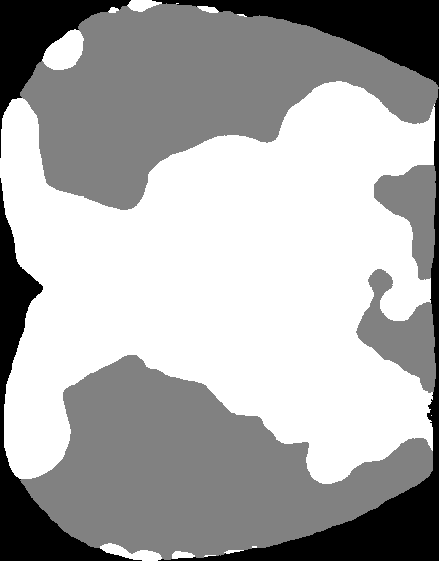

In [1]:
load("../dougRaster/Rotated_and_Cropped/P431F1.mat")
pkg load image
aa = mat2gray(Petals.Clusters.right);
imshow(aa) %% that works.

We want to make polygons of spots and their petals. We can begin by "peeling" these two apart into separate, solid-black images:

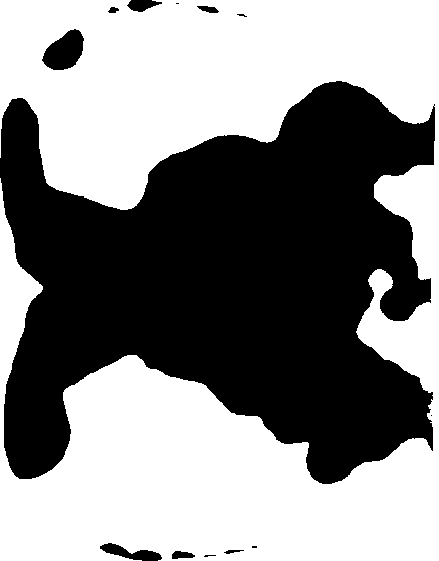

In [2]:
bb = aa < 1;
imshow(bb);


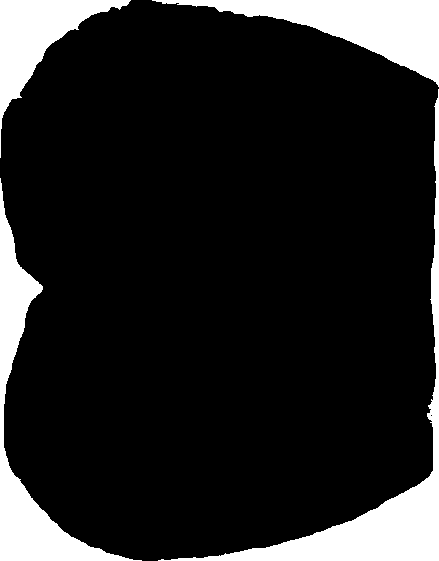

In [3]:
cc = aa == 0;
imshow(cc);

We save these and export them for gimp...

In [4]:
imwrite(bb, 'P431F1_bottom_spots.png')
imwrite(cc, 'P431F1_bottom_petal.png')

Leave matlab/octave for a moment. We'll use [GIMP](https://www.gimp.org/) for detecting the edges of these black-and-white images we've created. Gimp has a command line mode that can run scripts. I wrote a script in GIMP's scriptfu language to export an svg of the edges of these petal and spot shapes:

In [2]:
cat makePetalPoly.scm

(define(makePetalPoly filename)
    (let* (
            ;; load files, set vars
            (image (car (gimp-file-load 
                                0 
                                filename 
                                filename
                        ) 
                    ) 
            )
            (drawable (car (gimp-image-get-active-layer image)))
            (outPut (string-append filename "_path.svg"))
          )
            ;; do stuff
            ;;1 select black/solid regions:
            (gimp-image-select-color 
                image
                CHANNEL-OP-REPLACE
                drawable
                '(0 0 0) ;; black
            )
            ;;2 Convert selection to path
            (plug-in-sel2path
                RUN-NONINTERACTIVE
                image
                drawable
            ) 
            ;;3 save path to file
        (gimp-vectors-export-to-file
            image
            ;"/Users/danthomas/Documents/speckling/make_polygons/spo

---
To use this script, place it in one of the directories that GIMP uses for scripts. In gimp 2.8, you can find this by looking in `Edit --> Preferences --> Folders --> Scripts. `

On my Ubuntu machine we use GIMP and the script like this:

In [3]:
gimp -i -b '(makePetalPoly "P431F1_bottom_spots.png")' -b '(gimp-quit 0)'


(gimp:1249): GLib-GObject-WARNING **: g_object_set_valist: object class 'GeglConfig' has no property named 'cache-size'

(gimp:1249): GEGL-gegl-operation.c-WARNING **: Cannot change name of operation class 0x2CD4940 from "gimp:point-layer-mode" to "gimp:dissolve-mode"

(gimp:1249): GEGL-gegl-operation.c-WARNING **: Cannot change name of operation class 0x2CD4D50 from "gimp:point-layer-mode" to "gimp:behind-mode"

(gimp:1249): GEGL-gegl-operation.c-WARNING **: Cannot change name of operation class 0x2CD50F0 from "gimp:point-layer-mode" to "gimp:multiply-mode"

(gimp:1249): GEGL-gegl-operation.c-WARNING **: Cannot change name of operation class 0x2CD6200 from "gimp:point-layer-mode" to "gimp:screen-mode"

(gimp:1249): GEGL-gegl-operation.c-WARNING **: Cannot change name of operation class 0x2CD65D0 from "gimp:point-layer-mode" to "gimp:overlay-mode"

(gimp:1249): GEGL-gegl-operation.c-WARNING **: Cannot change name of operation class 0x2CD6A00 from "gimp:point-layer-mode" to "gimp:diffe

Not sure about the GEGL-related warnings. But this then gives us an svg made of bezier curves:

![](P431F1_bottom_spots.png_path.svg)

This looks quite nice. Unfortunately, I haven't yet figured out how to conserve these nice curves into something that matlab will accept as polygons. We can flattened these curves by removing their control points and converting them to lines. We can do this with a big regex in SED (which might have to be modified for mac OS SED):

In [5]:
cp P431F1_bottom_spots.png_path.svg test.svg
sed '/^\s*C/ s/C\s/L /' test.svg | \
sed -e 's/\([0-9]*\.[0-9]*,[0-9]*\.[0-9]*\) \([0-9]*\.[0-9]*,[0-9]*\.[0-9]*\) \([0-9]*\.[0-9]*,[0-9]*\.[0-9]*\)/\1/g' > test2.svg

![](test2.svg)

This is a less than perfect solution, so let's spend more time on this. Let's see if a quick dip into python, in particular [scikit-image](https://scikit-image.org/), can help us. 

---

Let's get our images out of matlab/octave:

In [1]:
## in octave:
pkg load image

## get one grayscale image:
load("../dougRaster/Rotated_and_Cropped/P431F1.mat")
aa = mat2gray(Petals.Clusters.right);

## remake our images:
spots = aa < 1;

petal = aa == 0;

## save them as csv's:

csvwrite('P431F1petal.csv',petal)
csvwrite('P431F1spots.csv',spots)

Then see if we can visualize them in Python:

In [1]:
## python
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, io, filters, measure

petal = np.genfromtxt ('P431F1petal.csv', delimiter=",")
spots = np.genfromtxt ('P431F1spots.csv', delimiter=",")

The contour module should be able to outline these spots and break them up into their individual polygons.

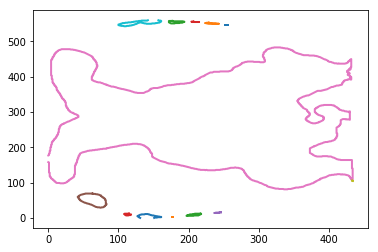

In [2]:
contours = measure.find_contours(spots, 0)
for n, contour in enumerate(contours):
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2)

#plt.show()

Close! Looks like the contours are being interrupted by our borders. Tomorrow, let's add margins for this. 